## Laboratorium 7


## Detekcja obiektów za pomocą Faster-RCNN

### Wprowadzenie

Celem tej listy jest praktyczne zapoznanie się z działaniem dwuetapowych modeli do detekcji obiektów na przykładzie Faster R-CNN. Skorzystamy z gotowej implementacji modelu z pakietu [`torchvision`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py). Jeżeli masz inny ulubiony model działający na podobnej zasadzie, możesz z niego skorzystać zamiast podanego. Podobnie implementacja - jeśli masz swoją ulubioną bibliotekę np. Detectron2, MMDetection, możesz z niej skorzystać.

W zadaniu wykorzystany zostanie zbiór danych [_Chess Pieces Dataset_](https://public.roboflow.com/object-detection/chess-full) (autorstwa Roboflow, domena publiczna), ZIP z obrazami i anotacjami powinien być dołączony do instrukcji.

Podczas realizacji tej listy większy nacisk położony zostanie na inferencję z użyciem Faster R-CNN niż na uczenie (które przeprowadzisz raz\*). Kluczowe komponenty w tej architekturze (RPN i RoIHeads) można konfigurować bez ponownego uczenia, dlatego badania skupią się na ich strojeniu. Aby zrozumieć działanie modelu, konieczne będzie spojrzenie w jego głąb, włącznie z częściowym wykonaniem. W tym celu warto mieć na podorędziu kod źródłowy, w szczególności implementacje następujących klas (uwaga - linki do najnowszej implementacji; upewnij się więc, że czytasz kod używanej przez siebie wersji biblioteki):
* `FasterRCNN`: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py
* `GeneralizedRCNN`: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/generalized_rcnn.py
* `RegionProposalNetwork`: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py
* `RoIHeads`: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py

Dogłębne zrozumienie procedury uczenia modelu nie będzie wymagane, niemniej należy mieć ogólną świadomość jak ten proces przebiega i jakie funkcje kosztu są wykorzystywane. Użyjemy gotowej implementacji z submodułu [`references.detection`](https://github.com/pytorch/vision/blob/main/references/detection/train.py) w nieco uproszczonej wersji. Ponieważ ten moduł **nie** jest domyślnie instalowaną częścią pakietu `torchvision`, do instrukcji dołączono jego kod w nieznacznie zmodyfikowanej wersji (`references_detection.zip`).
Jeśli ciekawią Cię szczegóły procesu uczenia, zachęcam do lektury [artykułu](https://arxiv.org/abs/1506.01497) i analizy kodu implementacji.

In [123]:
!pip install pycocotools


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


### Zadanie 0: Uczenie

Krokiem "zerowym" będzie przygotowanie wstępnie nauczonego modelu i douczenie go na docelowym zbiorze.
Podany zestaw hiperparametrów powinien dawać przyzwoite (niekoniecznie idealne) wyniki - jeśli chcesz, śmiało dobierz swoje własne; nie spędzaj na tym jednak zbyt wiele czasu.

Twoim zadaniem jest nie tylko przeklikanie poniższych komórek, ale przynajmniej ogólne zrozumienie procesu uczenia (przejrzyj implementację `train_one_epoch`) i struktury modelu.

In [124]:
import os
import time
import datetime

import torch
import torch.utils.data
import torchvision
import torchvision.models.detection as M
from torchvision.io.image import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

from detection import coco_utils, presets, utils, transforms
from detection.engine import train_one_epoch, evaluate

In [125]:
def get_dataset(img_root: str, file_name: str, train: bool = True):
    """Reimplementacja analogicznej funkcji z pakietu references, rozwiązująca drobną niekompatybilność w zbiorze CPD"""

    def fake_segmentation(image, target):
        for obj in target["annotations"]:
            x, y, w, h = obj["bbox"]
            segm = [x, y, x + w, y, x + w, y + h, x, y + h]
            obj["segmentation"] = [segm]
        return image, target

    tfs = transforms.Compose(
        [
            fake_segmentation,
            coco_utils.ConvertCocoPolysToMask(),
            (
                presets.DetectionPresetTrain(data_augmentation="hflip")
                if train
                else presets.DetectionPresetEval()
            ),
            # jeśli chcesz dodać swoje własne augmentacje, możesz zrobić to tutaj
        ]
    )
    ds = coco_utils.CocoDetection(img_root, file_name, transforms=tfs)
    return ds

In [126]:
# Konfiguracja hiperparametrów
LR = 0.001  # powinno być dobrze dla 1 GPU
WDECAY = 0.0001
EPOCHS = 25
VAL_FREQ = 5  # walidacja i checkpointowanie co N epok
BATCH_SIZE = 2  # dobierz pod możliwości sprzętowe
NUM_WORKERS = 8  # j/w
NUM_CLASSES = 14
DEVICE = "cuda:0"
DATASET_ROOT = "chess/"
OUTPUT_DIR = "outputs/"

In [127]:
# Zaczytanie datasetów
chess_train = get_dataset(
    os.path.join(DATASET_ROOT, "train"),
    os.path.join(DATASET_ROOT, "train/_annotations.coco.json"),
)
chess_val = get_dataset(
    os.path.join(DATASET_ROOT, "valid"),
    os.path.join(DATASET_ROOT, "valid/_annotations.coco.json"),
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [128]:
# samplery i loadery
train_sampler = torch.utils.data.RandomSampler(chess_train)
train_batch_sampler = torch.utils.data.BatchSampler(
    train_sampler, BATCH_SIZE, drop_last=True
)
train_loader = torch.utils.data.DataLoader(
    chess_train,
    batch_sampler=train_batch_sampler,
    num_workers=NUM_WORKERS,
    collate_fn=utils.collate_fn,
)

val_sampler = torch.utils.data.SequentialSampler(chess_val)
val_loader = torch.utils.data.DataLoader(
    chess_val,
    batch_size=1,
    sampler=val_sampler,
    num_workers=NUM_WORKERS,
    collate_fn=utils.collate_fn,
)

In [129]:
# Skonstruowanie modelu; tworzymy w wersji dla 91 klas aby zainicjować wagi wstępnie nauczone na COCO...
model = M.fasterrcnn_resnet50_fpn(
    weights=M.FasterRCNN_ResNet50_FPN_Weights.COCO_V1, num_classes=91
).to(DEVICE)
# ...po czym zastępujemy predyktor mniejszym, dostosowanym do naszego zbioru:
model.roi_heads.box_predictor = M.faster_rcnn.FastRCNNPredictor(
    in_channels=1024, num_classes=NUM_CLASSES
).to(DEVICE)

In [130]:
model  # zwróć uwagę na strukturę Box Predictora (dlaczego tyle out_features?)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Zanim przejdziemy do uczenia pełnego modelu, wykonamy krótkie wstępne uczenie losowo zainicjowanego predyktora:
train_one_epoch(
    model=model,
    optimizer=torch.optim.AdamW(
        model.roi_heads.box_predictor.parameters(), lr=LR, weight_decay=WDECAY
    ),
    data_loader=train_loader,
    device=DEVICE,
    epoch=0,
    print_freq=20,
    scaler=None,
)

In [ ]:
# Zapisywanie nauczonych modeli
model_path = "trained_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

In [ ]:
# Uczenie pełnego modelu
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad], lr=LR, weight_decay=WDECAY
)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[10], gamma=0.1
)  # dobierz wartości jeśli trzeba

start_time = time.time()
for epoch in range(EPOCHS):
    train_one_epoch(model, optimizer, train_loader, DEVICE, epoch, 20, None)
    lr_scheduler.step()

    # eval and checkpoint every VAL_FREQ epochs
    if (epoch + 1) % VAL_FREQ == 0:
        checkpoint = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "lr_scheduler": lr_scheduler.state_dict(),
            "epoch": epoch,
        }
        utils.save_on_master(checkpoint, os.path.join(OUTPUT_DIR, f"model_{epoch}.pth"))
        utils.save_on_master(checkpoint, os.path.join(OUTPUT_DIR, "checkpoint.pth"))
        evaluate(model, val_loader, device=DEVICE)

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Training time {total_time_str}")

In [131]:
import matplotlib.pyplot as plt

Image saved to prediction_with_boxes.jpg


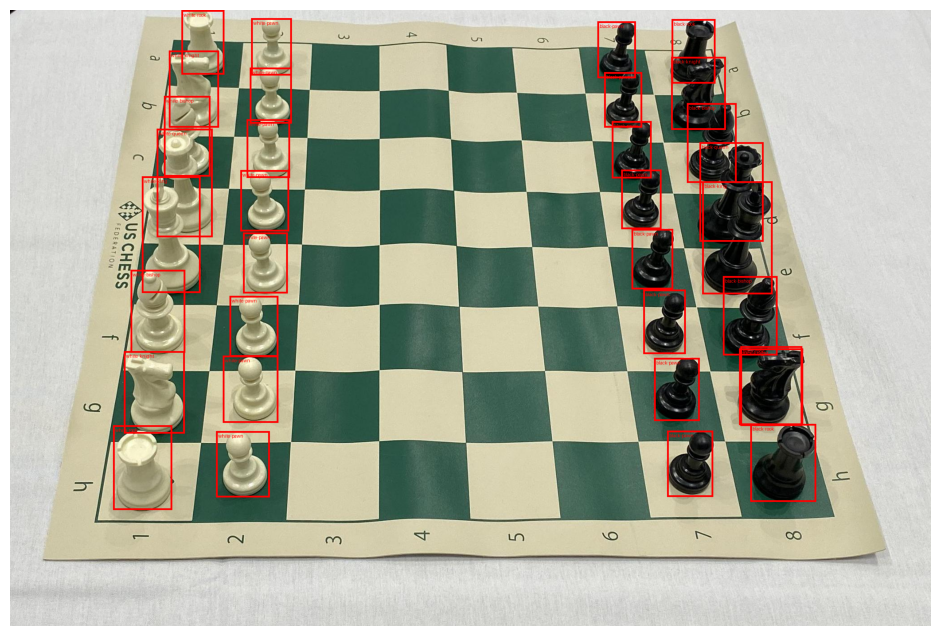

In [134]:
model.eval()

# Inferencja na zadanym obrazie
preprocess = (
    M.FasterRCNN_ResNet50_FPN_Weights.COCO_V1.transforms()
)  # to wystarczy pobrać raz
img = read_image(
    os.path.join(
        DATASET_ROOT, "test/IMG_0159_JPG.rf.1cf4f243b5072d63e492711720df35f7.jpg"
    )
)
batch = [preprocess(img).to(DEVICE)]
prediction = model(batch)[0]
# Rysowanie predykcji - wygodny gotowiec
box = draw_bounding_boxes(
    img,
    boxes=prediction["boxes"],
    labels=[chess_train.coco.cats[i.item()]["name"] for i in prediction["labels"]],
    colors="red",
    width=4,
)
# to_pil_image(box.detach()).show()

# Save the image with bounding boxes
output_path = "prediction_with_boxes.jpg"
to_pil_image(box.detach()).save(output_path)

print(f"Image saved to {output_path}")
# Display the image with bounding boxes using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(box.permute(1, 2, 0))
plt.axis("off")
plt.show()

---
### Zadanie 1

Zbadaj wpływ parametrów inferencji **głowic `RoIHeads`**, progu prawdopodobieństwa (`score_thresh`) i progu NMS (`nms_thresh`), na działanie modelu. Wykorzystaj funkcję `evaluate` aby zmierzyć zmianę jakości predykcji, ale przebadaj też efekty wizualnie, wyświetlając predykcje dla kilku obrazów ze zbioru walidacyjnego i kilku spoza zbioru (folder `wild`). _W finalnej wersji pozostaw tylko wybrane interesujące przykłady._

- `score_thresh` - próg dla minimalnej wartości pewności predykcji, powyżej której model uznaje detekcję za wartą zachowania
    - niski próg (np. 0.01)
        - więcej detekcji
        - więcej false positive
        - mniej false negative  
        - wysoki recall
        - niskie precision
    - wysoki próg (np. 0.1)
        - mniej detekcji
        - mniej false positive
        - więcej false negative 
- `nms_thresh` - Non-Maximum Suppression (NMS) - określa próg jak bardzo mogą nakładać się bounding boxy (wg. wartości IoU)
    - Zawsze jedna detekcja o największym score jest zachowana
    - Dla każdej z detekcji, oblicza IoU z pozostałymi:
    - Usuwa detekcję, jeśli IoU > nms_thresh 
    - Niskie wartości (np. 0.3) - usuwa więcej detekcji
    - Wysokie wartości (np. 0.7) - usuwa mniej detekcji

In [13]:
print(DEVICE)

cuda:0


In [23]:
import matplotlib.pyplot as plt
import pandas as pd

#### Load model from checkpoint

In [133]:
model = M.fasterrcnn_resnet50_fpn(
    weights=M.FasterRCNN_ResNet50_FPN_Weights.COCO_V1, num_classes=91
).to(DEVICE)

model.roi_heads.box_predictor = M.faster_rcnn.FastRCNNPredictor(
    in_channels=1024, num_classes=NUM_CLASSES
).to(DEVICE)

checkpoint_file = "checkpoint.pth"
checkpoint = torch.load(checkpoint_file)

model.load_state_dict(checkpoint["model"])

/tmp/ipykernel_2400695/4223494447.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


<All keys matched successfully>

In [119]:
print(f"Score threshold: {model.roi_heads.score_thresh}")
print(f"NMS threshold: {model.roi_heads.nms_thresh}")

Score threshold: 0.05
NMS threshold: 0.5


In [16]:
test_image = os.path.join(
    DATASET_ROOT, "test/IMG_0159_JPG.rf.1cf4f243b5072d63e492711720df35f7.jpg"
)

#### Get evaluation scores on validation dataset

In [17]:
nms_thresh = 0.1
res = evaluate(model, val_loader, device=DEVICE)
print(res)

Test:  [ 0/58]  eta: 0:01:29  model_time: 0.6447 (0.6447)  evaluator_time: 0.0035 (0.0035)  time: 1.5434  data: 0.8844  max mem: 2166
Test:  [57/58]  eta: 0:00:00  model_time: 0.6318 (0.6326)  evaluator_time: 0.0009 (0.0018)  time: 0.6504  data: 0.0083  max mem: 2166
Test: Total time: 0:00:38 (0.6676 s / it)
Averaged stats: model_time: 0.6318 (0.6326)  evaluator_time: 0.0009 (0.0018)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.403
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

In [18]:
# Get structure of CocoEvaluator results
# for iou_type, coco_eval in res.coco_eval.items():
#     print(f"\nMetrics for {iou_type}:")
#     print("Evaluation metrics:", coco_eval.stats)
#     print("\nParameter names:")
#     print(coco_eval.params.__dict__.keys())


Metrics for bbox:
Evaluation metrics: [ 0.32950316  0.43174997  0.40333566 -1.         -1.          0.32950316
  0.39695687  0.508842    0.508842   -1.         -1.          0.508842  ]

Parameter names:
dict_keys(['imgIds', 'catIds', 'iouThrs', 'recThrs', 'maxDets', 'areaRng', 'areaRngLbl', 'useCats', 'iouType', 'useSegm'])


#### Get evaluation metrics for different score thresholds

In [94]:
print("Testing Score Thresholds:")
score_thresholds = [0.00001, 0.0001, 0.001, 0.01, 0.1]
nms_thresh = 0.5

model.roi_heads.nms_thresh = nms_thresh
results = []
for score_thresh in score_thresholds:
    model.roi_heads.score_thresh = score_thresh

    print(f"\nScore threshold: {score_thresh}")
    evaluation = evaluate(model, val_loader, device=DEVICE)
    result = {
        "score_threshold": score_thresh,
        "evaluation": evaluation,
    }
    results.append(result)

# Save results in a dataframe
score_results_df = pd.DataFrame(results)
print(score_results_df)

Testing Score Thresholds:

Score threshold: 1e-05
Test:  [ 0/58]  eta: 0:01:25  model_time: 0.6500 (0.6500)  evaluator_time: 0.0068 (0.0068)  time: 1.4784  data: 0.8048  max mem: 2166
Test:  [57/58]  eta: 0:00:00  model_time: 0.6491 (0.6443)  evaluator_time: 0.0019 (0.0036)  time: 0.6676  data: 0.0080  max mem: 2166
Test: Total time: 0:00:39 (0.6793 s / it)
Averaged stats: model_time: 0.6491 (0.6443)  evaluator_time: 0.0019 (0.0036)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.220
 Average Reca

In [96]:
score_results_file = "score_thresh_results.pkl"
score_results_df.to_pickle(score_results_file)

In [97]:
score_results_df = pd.read_pickle(score_results_file)

In [98]:
display(score_results_df)

score_threshold                                         evaluation
0          0.00001  <detection.coco_eval.CocoEvaluator object at 0...
1          0.00010  <detection.coco_eval.CocoEvaluator object at 0...
2          0.00100  <detection.coco_eval.CocoEvaluator object at 0...
3          0.01000  <detection.coco_eval.CocoEvaluator object at 0...
4          0.10000  <detection.coco_eval.CocoEvaluator object at 0...

In [71]:
def plot_coco_metrics(results_df, x_key="score_threshold", x_label="Score Threshold"):
    """
    Plot COCO evaluation metrics (Average Precision and Average Recall) from a DataFrame.

    Args:
        results_df (pd.DataFrame): DataFrame containing evaluation results.
            - `x_key`: A numerical column to use as the x-axis (e.g., `score_threshold`, `nms_threshold`).
            - `evaluation`: A column with CocoEvaluator objects containing metrics.
        x_key (str): The column name to use for the x-axis (e.g., `score_threshold`, `nms_threshold`).
        x_label (str): The label for the x-axis.

    Returns:
        None: Displays the bar charts for AP and AR metrics.
    """

    # Extract metrics from the CocoEvaluator objects
    def extract_metrics(evaluation):
        coco_eval = evaluation.coco_eval["bbox"]
        if coco_eval is not None:
            return {
                "AP_50_95": coco_eval.stats[0],  # AP @ IoU=0.50:0.95
                "AP_50": coco_eval.stats[1],  # AP @ IoU=0.50
                "AP_75": coco_eval.stats[2],  # AP @ IoU=0.75
                "AR_50_95_1": coco_eval.stats[6],  # AR @ IoU=0.50:0.95, maxDets=1
                "AR_50_95_10": coco_eval.stats[7],  # AR @ IoU=0.50:0.95, maxDets=10
                "AR_50_95_100": coco_eval.stats[8],  # AR @ IoU=0.50:0.95, maxDets=100
            }
        return {
            "AP_50_95": None,
            "AP_50": None,
            "AP_75": None,
            "AR_50_95_1": None,
            "AR_50_95_10": None,
            "AR_50_95_100": None,
        }

    # Add extracted metrics to the DataFrame
    metrics_df = results_df["evaluation"].apply(extract_metrics).apply(pd.Series)
    results_df = pd.concat([results_df, metrics_df], axis=1)

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))

    # Top Plot: Average Precision (AP) Metrics
    ap_columns = ["AP_50_95", "AP_50", "AP_75"]
    ap_values = results_df[ap_columns].T
    ap_values.columns = results_df[x_key].astype(str)

    ap_values.plot(
        kind="bar",
        ax=axes[0],
        legend=True,
        title="Average Precision (AP) Metrics",
        xlabel="Metrics",
        ylabel="Average Precision (AP)",
    )
    axes[0].legend(title=x_label)
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)

    # Bottom Plot: Average Recall (AR) Metrics
    ar_columns = ["AR_50_95_1", "AR_50_95_10", "AR_50_95_100"]
    ar_values = results_df[ar_columns].T
    ar_values.columns = results_df[x_key].astype(str)

    ar_values.plot(
        kind="bar",
        ax=axes[1],
        legend=True,
        title="Average Recall (AR) Metrics",
        xlabel="Metrics",
        ylabel="Average Recall (AR)",
    )
    axes[1].legend(title=x_label)
    axes[1].grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

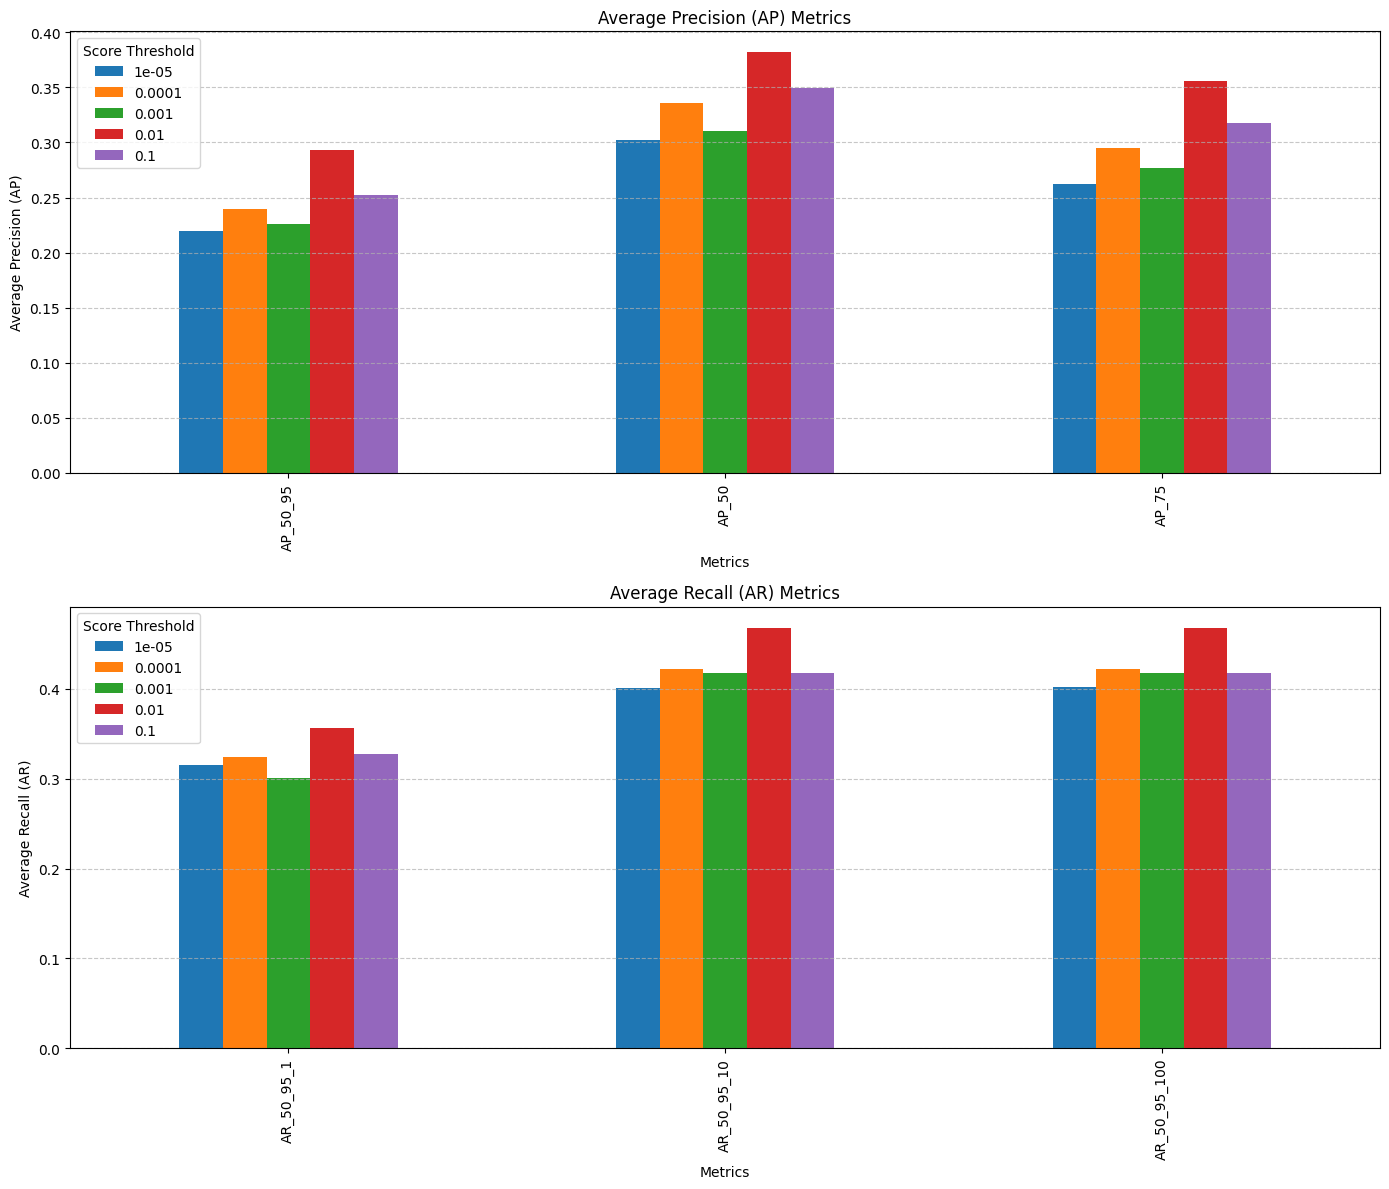

In [99]:
plot_coco_metrics(score_results_df, x_key="score_threshold", x_label="Score Threshold")

#### Get evaluation metrics for different nms thresholds

In [74]:
print("\nTesting NMS Thresholds:")

nms_thresholds = [0.3, 0.5, 0.7]
score_thresh = 0.05
nms_thresh = 0.5

model.roi_heads.score_thresh = score_thresh
results = []
for nms_thresh in nms_thresholds:
    model.roi_heads.nms_thresh = nms_thresh

    print(f"\nScore threshold: {nms_thresh}")
    evaluation = evaluate(model, val_loader, device=DEVICE)
    result = {
        "nms_threshold": nms_thresh,
        "evaluation": evaluation,
    }
    results.append(result)

nms_results_df = pd.DataFrame(results)
print(nms_results_df)


Testing NMS Thresholds:

Score threshold: 0.3
Test:  [ 0/58]  eta: 0:01:24  model_time: 0.6445 (0.6445)  evaluator_time: 0.0037 (0.0037)  time: 1.4611  data: 0.7973  max mem: 2166
Test:  [57/58]  eta: 0:00:00  model_time: 0.6333 (0.6348)  evaluator_time: 0.0009 (0.0018)  time: 0.6553  data: 0.0080  max mem: 2166
Test: Total time: 0:00:38 (0.6678 s / it)
Averaged stats: model_time: 0.6333 (0.6348)  evaluator_time: 0.0009 (0.0018)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.107
 Average Recall 

In [89]:
nms_thresh_results_file = "nms_thresh_results.pkl"
nms_results_df.to_pickle(nms_thresh_results_file)

In [90]:
nms_results_df = pd.read_pickle(nms_thresh_results_file)

In [91]:
display(nms_results_df)

nms_threshold                                         evaluation
0            0.3  <detection.coco_eval.CocoEvaluator object at 0...
1            0.5  <detection.coco_eval.CocoEvaluator object at 0...
2            0.7  <detection.coco_eval.CocoEvaluator object at 0...

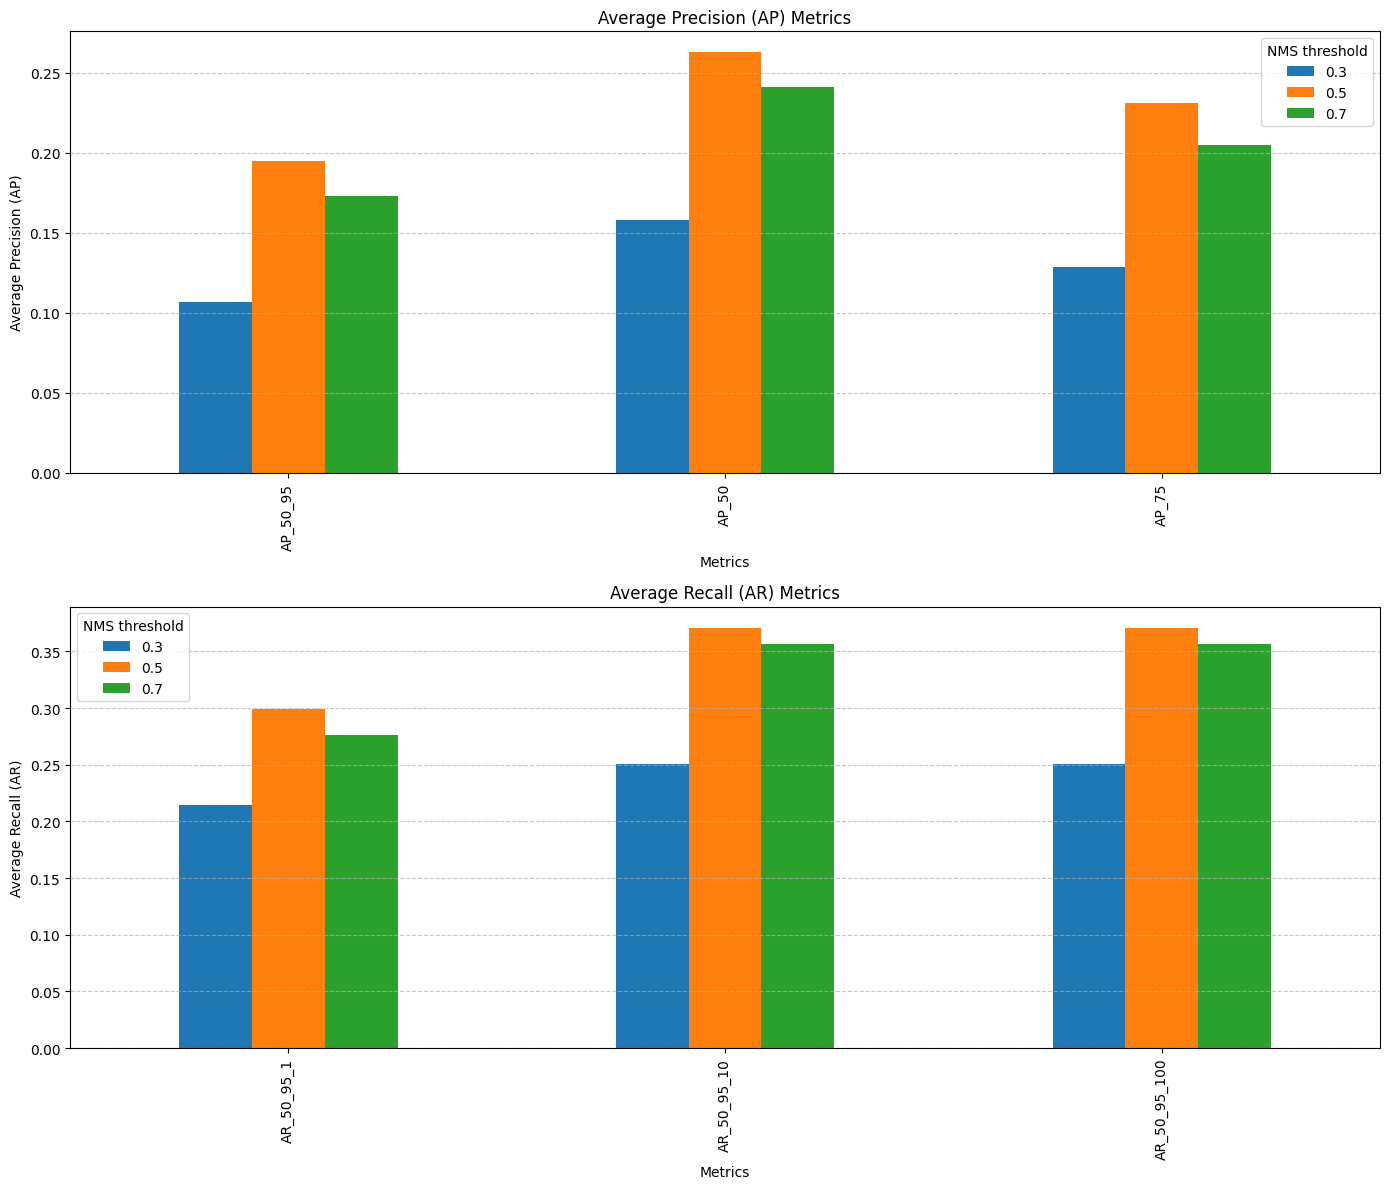

In [92]:
plot_coco_metrics(nms_results_df, x_key="nms_threshold", x_label="NMS threshold")

#### Visualize bbox predictions

In [102]:
import PIL
import os
import matplotlib.pyplot as plt

In [139]:
def visualize_predictions(model, image_path, title="") -> PIL.Image:
    img = read_image(image_path)
    preprocess = M.FasterRCNN_ResNet50_FPN_Weights.COCO_V1.transforms()
    batch = [preprocess(img).to(DEVICE)]

    with torch.no_grad():
        prediction = model(batch)[0]

    box = draw_bounding_boxes(
        img,
        boxes=prediction["boxes"],
        labels=[chess_train.coco.cats[i.item()]["name"] for i in prediction["labels"]],
        colors="red",
        width=4,
    )
    return to_pil_image(box.detach())

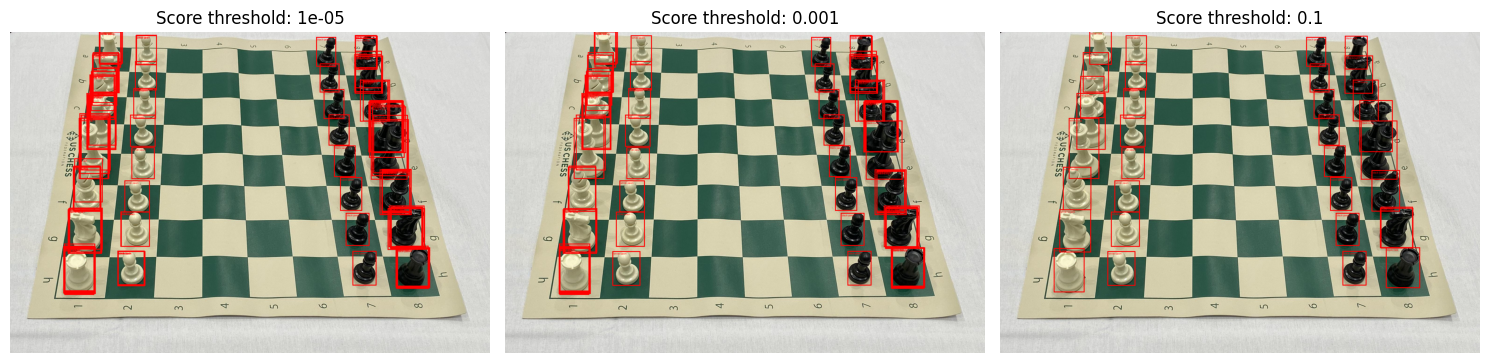

In [140]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
score_thresholds = [0.00001, 0.001, 0.1]

test_img = os.path.join(
    DATASET_ROOT, "test/IMG_0159_JPG.rf.1cf4f243b5072d63e492711720df35f7.jpg"
)

for i, thresh in enumerate(score_thresholds):
    model.roi_heads.score_thresh = thresh
    pred_img = visualize_predictions(model, test_img, f"Score threshold: {thresh}")

    # Convert PIL image to array for matplotlib
    axes[i].imshow(pred_img)
    axes[i].set_title(f"Score threshold: {thresh}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

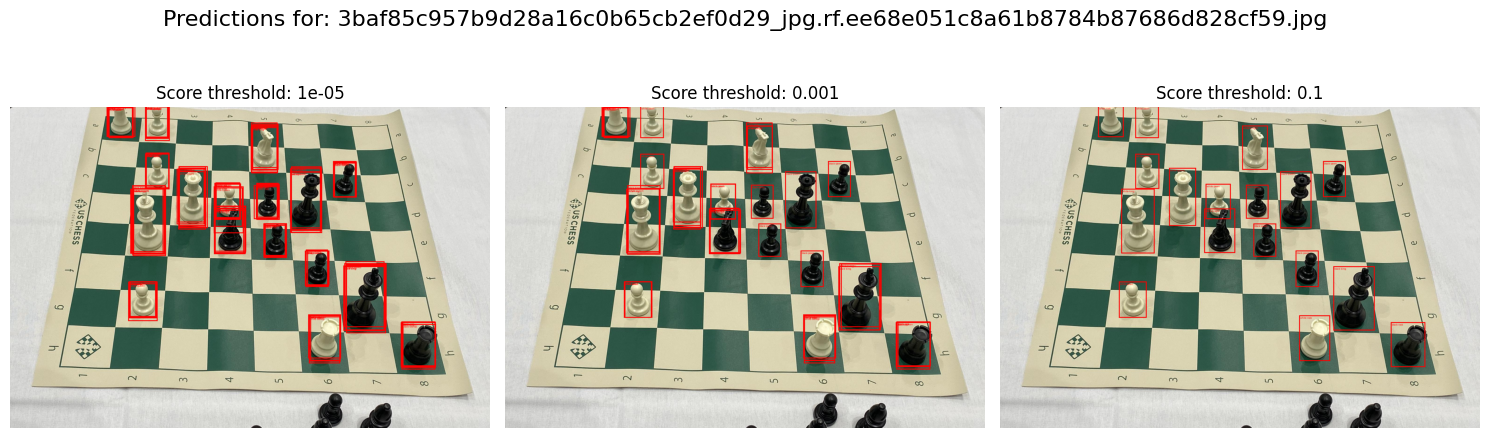

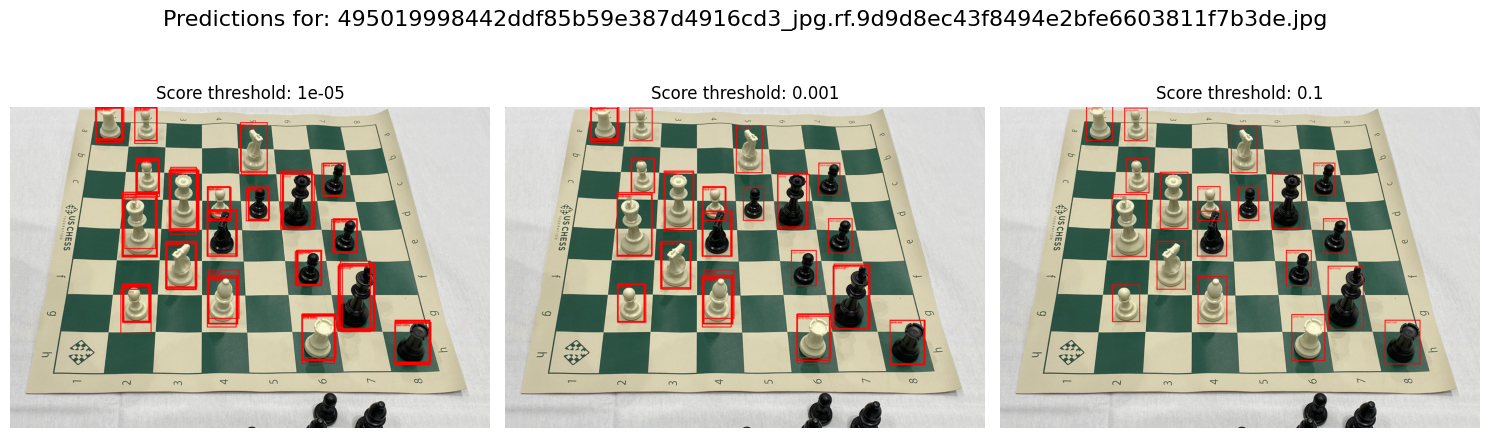

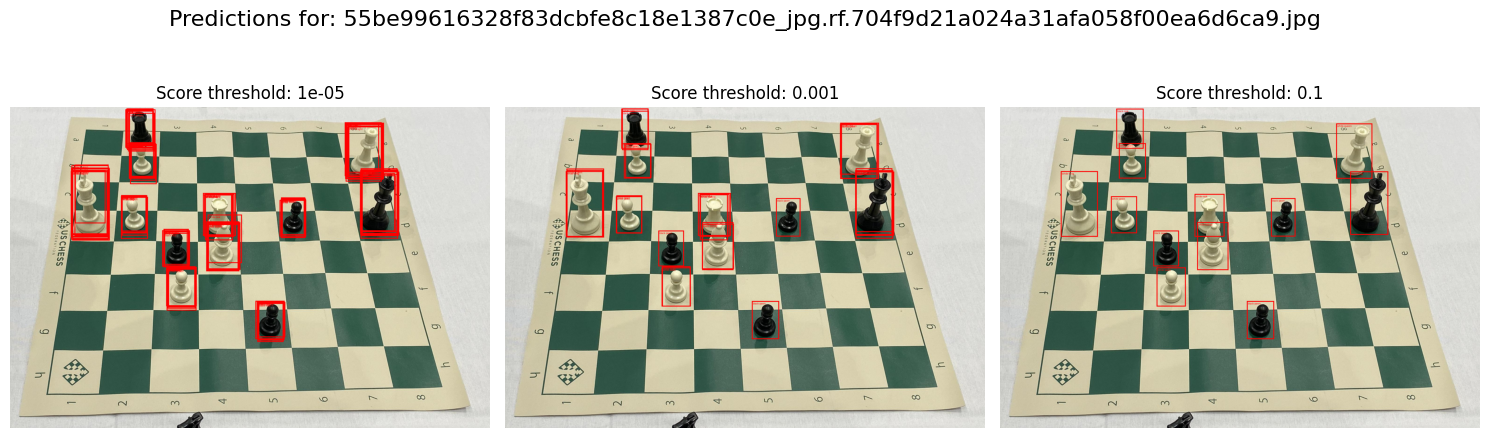

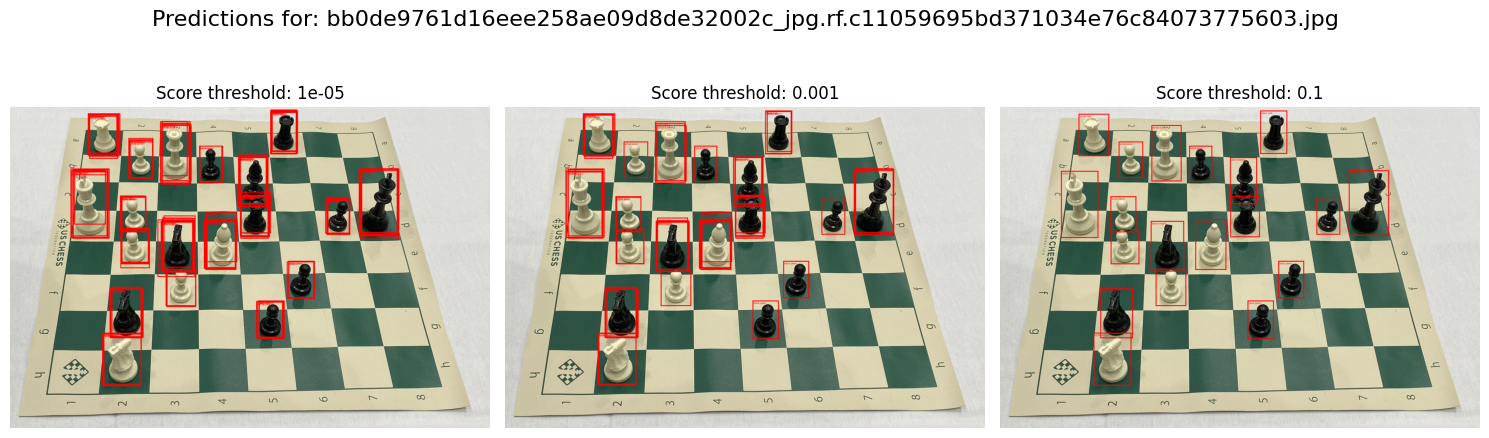

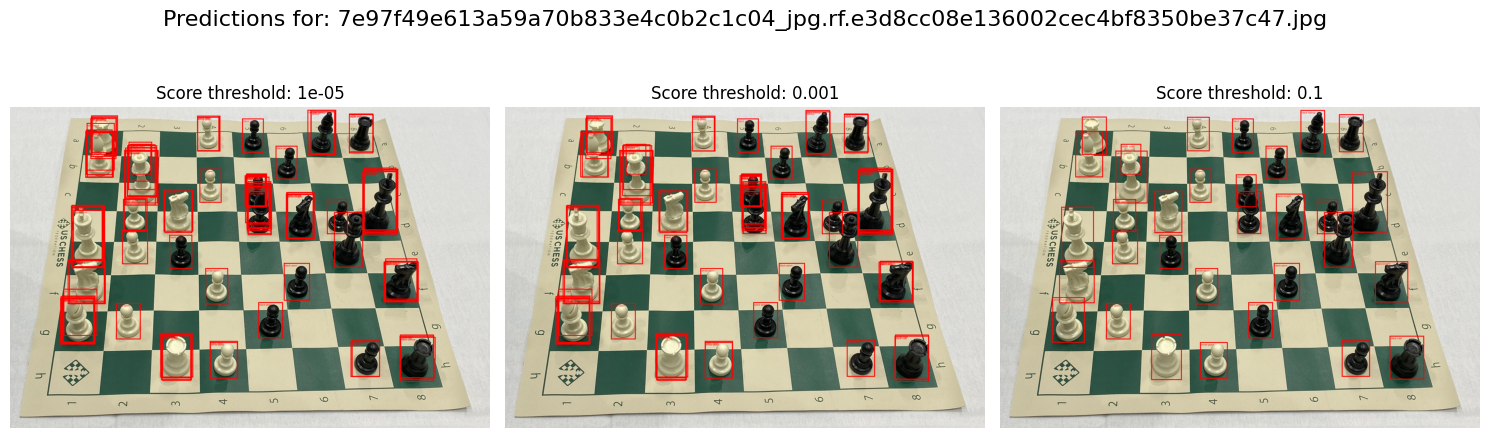

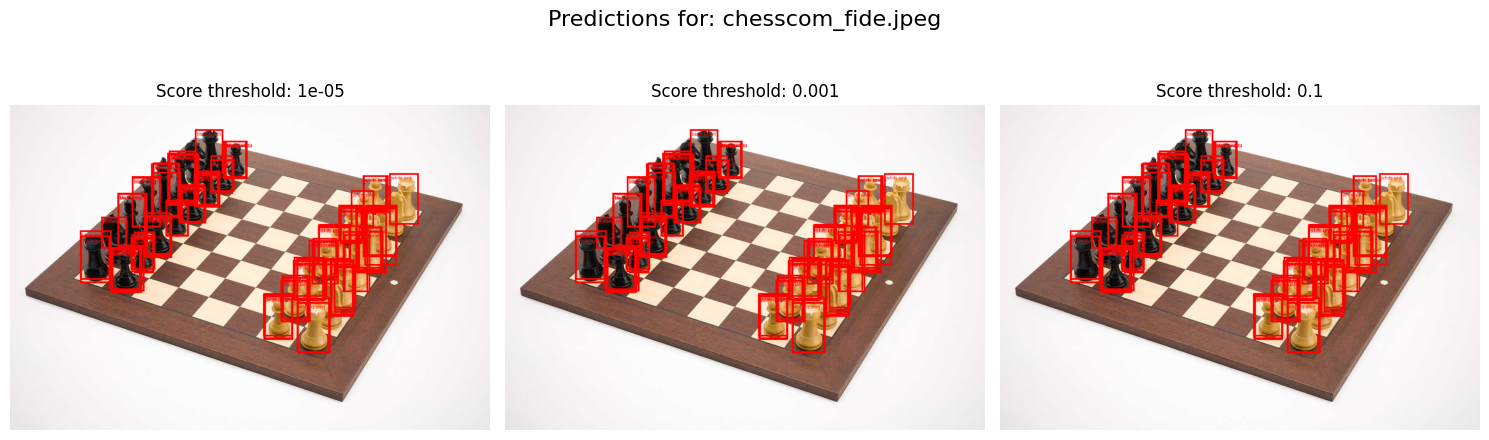

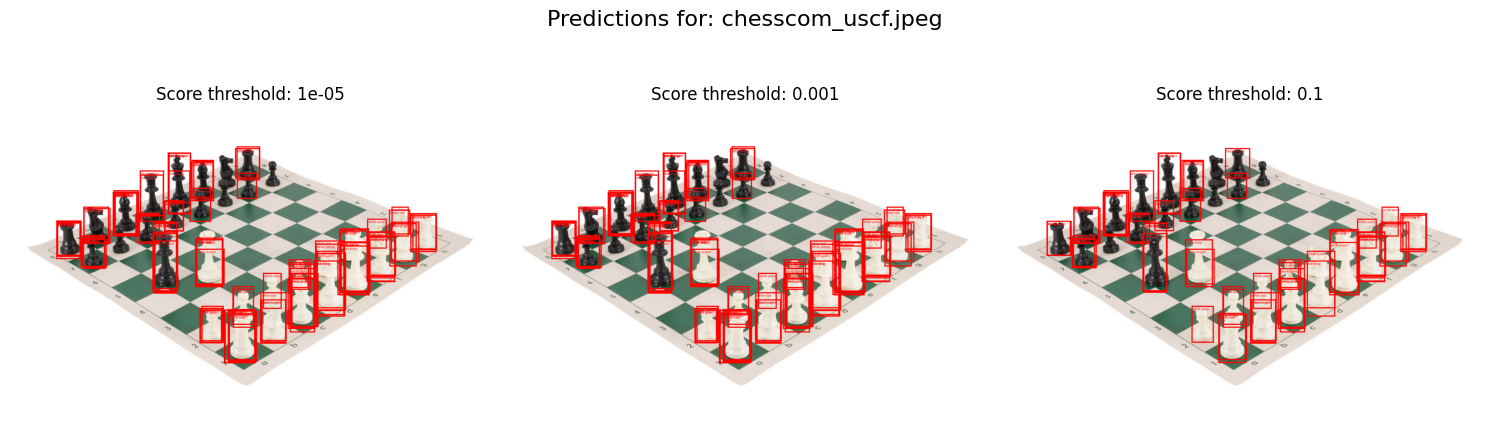

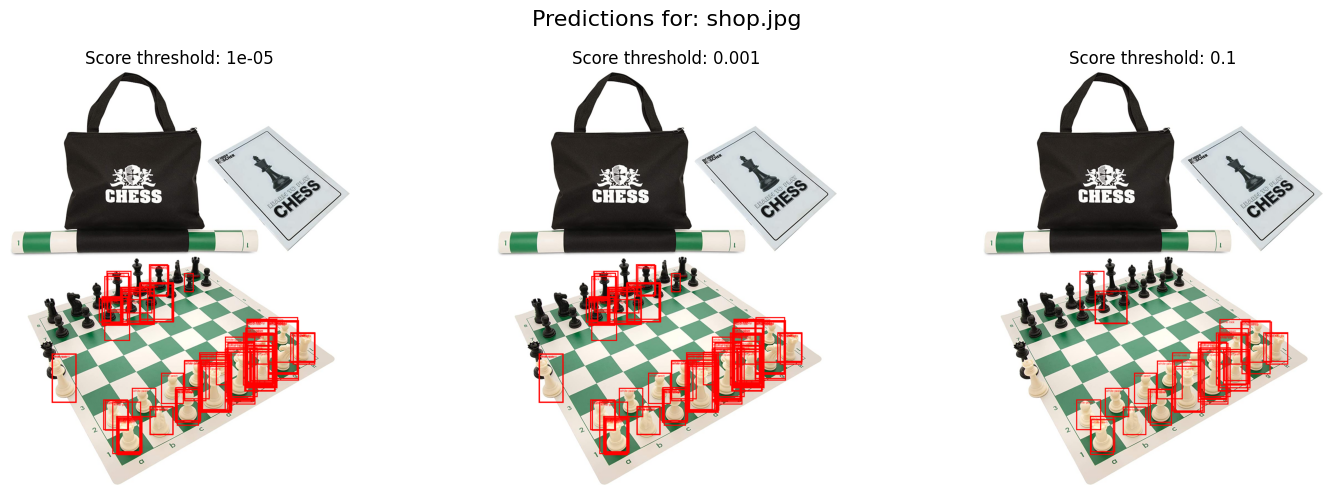

In [141]:
# Example file names
file_names = [
    "valid/3baf85c957b9d28a16c0b65cb2ef0d29_jpg.rf.ee68e051c8a61b8784b87686d828cf59.jpg",
    "valid/495019998442ddf85b59e387d4916cd3_jpg.rf.9d9d8ec43f8494e2bfe6603811f7b3de.jpg",
    "valid/55be99616328f83dcbfe8c18e1387c0e_jpg.rf.704f9d21a024a31afa058f00ea6d6ca9.jpg",
    "valid/bb0de9761d16eee258ae09d8de32002c_jpg.rf.c11059695bd371034e76c84073775603.jpg",
    "valid/7e97f49e613a59a70b833e4c0b2c1c04_jpg.rf.e3d8cc08e136002cec4bf8350be37c47.jpg",
    "wild/chesscom_fide.jpeg",
    "wild/chesscom_uscf.jpeg",
    "wild/shop.jpg",
]

score_thresholds = [0.00001, 0.001, 0.1]
DATASET_ROOT = "./chess"


# Loop through each file and create a chart for each image
for file_name in file_names:
    fig, axes = plt.subplots(1, len(score_thresholds), figsize=(15, 5))
    image_path = os.path.join(DATASET_ROOT, file_name)

    for i, thresh in enumerate(score_thresholds):
        # Set the model's score threshold
        model.roi_heads.score_thresh = thresh

        # Visualize predictions
        pred_img = visualize_predictions(
            model, image_path, f"Score threshold: {thresh}"
        )

        # Convert PIL image to array for matplotlib and display
        axes[i].imshow(pred_img)
        axes[i].set_title(f"Score threshold: {thresh}")
        axes[i].axis("off")

    # Add a title for the entire figure
    fig.suptitle(f"Predictions for: {os.path.basename(file_name)}", fontsize=16)
    plt.tight_layout()
    plt.show()

### Zadanie 2a

Zwizualizuj propozycje rejonów wygenerowane przez RPN i porównaj z ostateczną predykcją.

W tym celu konieczne będzie manualne wykonanie fragmentu metody `GeneralizedRCNN::forward` (patrz: [kod](https://github.com/pytorch/vision/blob/6279faa88a3fe7de49bf58284d31e3941b768522/torchvision/models/detection/generalized_rcnn.py#L46), link do wersji najnowszej na grudzień 2024).
Wszystkie fragmenty związane z uczeniem możesz rzecz jasna pominąć; chodzi o wyciągnięcie obiektu `proposals`.
Nie zapomnij o wykonaniu powrotnej transformacji! (Po co?)

### Zadanie 2b

Zbadaj wpływ progu NMS _na etapie propozycji_ na jakość predykcji oraz czas ich uzyskania.
Jak w poprzednich zadaniach, postaraj się nie ograniczyć tylko do pokazania metryk, ale pokaż wizualizacje (propozycji i predykcji) dla **wybranych** przykładów.